In [ ]:
# MY PROJECT TOPIC IS IMAGE STYLE TRANSFER

# PURPOSE OF THIS PROJECT IS TO MAKE A STYLIZED IMAGE BASED ON a content image and a style image

In [ ]:
#Importing necessary files
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras import Model
import matplotlib.pyplot as plt

In [ ]:
# Load VGG19 model pretrained on ImageNet
vgg_model = VGG19(include_top=False, weights='imagenet')
vgg_model.trainable = False

In [ ]:
#Choosing content and style images
content_image_path = "/content/content_image.jpeg"
style_image_path = "/content/style_image.jpeg"

In [ ]:
# Load and preprocess images
def load_and_preprocess_image(image_path):
    image = keras_image.load_img(image_path, target_size=(224, 224))#Load image from file and resize it to the target size (224x224)
    image = keras_image.img_to_array(image)
    image = np.expand_dims(image, axis=0)    # Add a batch dimension to the image (required by VGG19 model)
    image = tf.keras.applications.vgg19.preprocess_input(image)# Preprocess the image using the preprocess_input function of VGG19
    return image    # Return the preprocessed image

In [ ]:
# Define layers for content and style representation
content_layers = ['block4_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

In [ ]:
# Compute features from intermediate layers
def compute_features(image, model, content_layers, style_layers):
    outputs = [model.get_layer(layer).output for layer in (content_layers + style_layers)]
    model_features = Model(inputs=model.input, outputs=outputs)
    return model_features(image)

In [ ]:
# Define content and style loss functions
def content_loss(content_features, generated_features):
    return tf.reduce_mean(tf.square(content_features - generated_features))

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)# Compute the Gram matrix using Einstein summation ,The input_tensor refers to a tensor containing feature maps
    input_shape = tf.shape(input_tensor)                                   # Get the shape of the input tensor
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)# Calculate the number of locations (pixels) in the input tensor
    return result / num_locations                                       # Normalize the Gram matrix by the number of locations

def style_loss(style_features, generated_features):
    style_gram = gram_matrix(style_features)                    # Compute Gram matrices for style features and generated features
    generated_gram = gram_matrix(generated_features)
    return tf.reduce_mean(tf.square(style_gram - generated_gram))     # Compute squared difference between Gram matrices(MSE)


In [ ]:
# Define total loss function
def total_loss(content_targets, style_targets, content_weight, style_weight, generated_features):
    content_features = generated_features[:len(content_layers)]
    style_features = generated_features[len(content_layers):]

    content_loss_val = tf.add_n([content_loss(content_features[i], content_targets[i]) for i in range(len(content_layers))])
    style_loss_val = tf.add_n([style_loss(style_features[i], style_targets[i]) for i in range(len(style_layers))])

    total_loss = content_weight * content_loss_val + style_weight * style_loss_val #weights represents the priority
    return total_loss

In [ ]:
# Perform style transfer
def style_transfer(content_image_path, style_image_path, content_weight=1e3, style_weight=1e-2, learning_rate=5.0, num_iterations=1000):
        # Load and preprocess the content and style images

    content_image = load_and_preprocess_image(content_image_path)
    style_image = load_and_preprocess_image(style_image_path)
    # Compute content and style features from the VGG model

    content_targets = compute_features(content_image, vgg_model, content_layers, style_layers)[:len(content_layers)]
    style_targets = compute_features(style_image, vgg_model, content_layers, style_layers)[len(content_layers):]
    # Initialize the generated image as the content image

    generated_image = tf.Variable(content_image, dtype=tf.float32)
    # Define the optimizer
    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

    # Optimization loop

    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            # Compute features of the generated image
            generated_features = compute_features(generated_image, vgg_model, content_layers, style_layers)
            # Compute total loss
            loss = total_loss(content_targets, style_targets, content_weight, style_weight, generated_features)
        # Compute gradients and apply updates to the generated image
        gradients = tape.gradient(loss, generated_image)
        optimizer.apply_gradients([(gradients, generated_image)])
        # Print loss every 100 iterations

        if (i + 1) % 100 == 0:
            print(f"Iteration {i + 1}, Total Loss: {loss:.2f}")

    return generated_image

In [ ]:
stylized_image = style_transfer(content_image_path, style_image_path)

Iteration 100, Total Loss: 289480032.00
Iteration 200, Total Loss: 276470208.00
Iteration 300, Total Loss: 272747808.00
Iteration 400, Total Loss: 270941760.00
Iteration 500, Total Loss: 268605792.00
Iteration 600, Total Loss: 268460576.00
Iteration 700, Total Loss: 267693088.00
Iteration 800, Total Loss: 268674048.00
Iteration 900, Total Loss: 271357024.00
Iteration 1000, Total Loss: 265313984.00


In [ ]:
#To display images using OpenCV's imshow function in Colab notebook
from google.colab.patches import cv2_imshow

In [ ]:
class_names = ("Content Image","Style Image")
print(class_names)

('Content Image', 'Style Image')


Content Image
**************


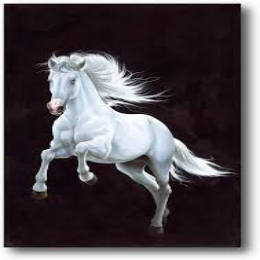

  
Style Image
************


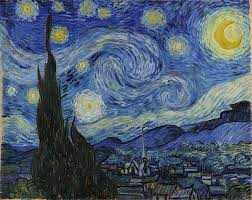

In [ ]:
#Displaying both Content image and Style image
content_image = cv2.imread('/content/content_image.jpeg')
content_image=cv2.resize(content_image,(260,260))
style_image = cv2.imread('/content/style_image.jpeg')
print(class_names[0])
print("**************")
cv2_imshow(content_image)
print("  ")
print(class_names[1])
print("************")
cv2_imshow(style_image)

In [ ]:
def display_image(image):
    image = np.squeeze(image, axis=0) # Remove the batch dimension if present,The batch dimension is typically added when loading multiple images, but for visualization, we want to remove it so that we can display a single image.
    image = image.astype(np.uint8)#converts the data type of the image array to unsigned 8-bit integers (uint8). This data type is suitable for displaying images with Matplotlib.
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Stylized Image
***************


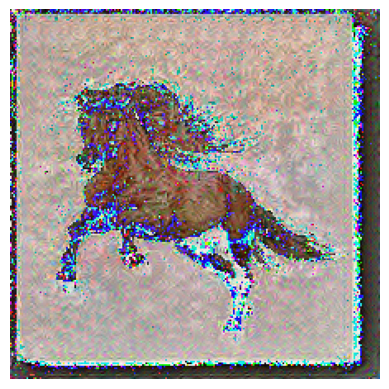

In [ ]:
print("Stylized Image")
print("***************")
display_image(stylized_image)

In [ ]:
from tensorflow.keras.models import save_model

save_model(vgg_model, 'vgg19_style_transfer_model.h5')

<ipython-input-55-712d7a17b02d>:3: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(vgg_model, 'vgg19_style_transfer_model.h5')
